In [5]:
import numpy as np
from collections import defaultdict
from openai import OpenAI
from tqdm import tqdm
from evaluate import load_data, parse_answer, check_answer_correctness, most_frequent_answer, judge_answers

In [6]:
agent_responses, dataset = load_data('results/mquake/adv_mquake_100_3_3_1.jsonl')
n_samples = len(agent_responses)
n_agents = len(agent_responses[0]['agent_responses'])
n_turns = len(agent_responses[0]['agent_responses'][0])//2

In [7]:
client = OpenAI()

In [8]:
agent_turn_correct = np.zeros((n_agents, n_turns))
agent_adversary = np.zeros(n_agents)
judge_vote = np.zeros(n_turns)
persuasiveness = np.zeros((n_agents, n_turns))
for agent_response in tqdm(agent_responses):

        question = agent_response['question']
        gt = agent_response['answer']
        raw_task = agent_response['raw_task']
        agents_conv = agent_response['agent_responses']

        all_answers = defaultdict(list)
        for agent, agent_conv in enumerate(agents_conv):
            adversary = False
            for context in agent_conv:
                if context['role'] == 'system':
                    adversary = True
                    agent_adversary[agent] = 1

                if context['role'] == 'assistant':
                    tmp_answer = parse_answer(dataset, context['content'], raw_task)
                    all_answers[agent].append(tmp_answer)


         
        np_all_answers = np.array(list(all_answers.values()))
        # compute answer correctness per round/agent
        for agent in range(n_agents):
            answers = np_all_answers[agent]
            for turn in range(n_turns):
                ans = answers[turn]
                agent_turn_correct[agent][turn] += check_answer_correctness(dataset, ans, gt)
        

        # compute judge vote per round
        for turn in range(n_turns):
            answers = np_all_answers[:, turn].tolist() 
            final_answer = judge_answers(answers, question, dataset, raw_task, client)
            judge_vote[turn] += check_answer_correctness(dataset, final_answer, gt)

            # return the agent index that provided the final answer
            final_answer_agent_indices = [i for i, answer in enumerate(answers) if answer == final_answer]
            if len(final_answer_agent_indices) > 1:
                persuasiveness[final_answer_agent_indices, turn] += 1
            
        # print('Answers: ', answers, "final answer: ", final_answer, "gt: ",  gt, 'correct: ', check_answer_correctness(dataset, final_answer, gt))
     

  0%|          | 0/100 [00:00<?, ?it/s]

retrying due to an error......


In [7]:
# Accuracy per agent
for agent in range(len(agent_turn_correct)):
    print(f"Agent {agent} #total: ", agent_turn_correct[agent])
    print(f"Agent {agent} acc: ", agent_turn_correct[agent]/n_samples)

Agent 0 #total:  [30. 29. 35.]
Agent 0 acc:  [0.3  0.29 0.35]
Agent 1 #total:  [55. 57. 52.]
Agent 1 acc:  [0.55 0.57 0.52]
Agent 2 #total:  [55. 58. 54.]
Agent 2 acc:  [0.55 0.58 0.54]


In [10]:
persuasiveness

array([[21., 12., 22.],
       [59., 52., 59.],
       [61., 52., 58.]])

In [8]:
normalized_persuasiveness = persuasiveness/persuasiveness.sum(axis=0)

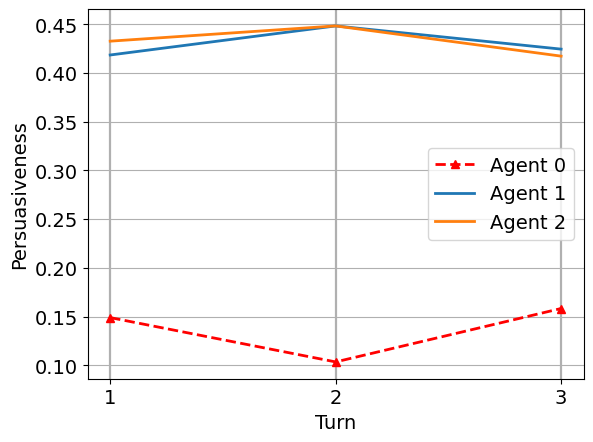

In [9]:
# plot persuasiveness
import matplotlib.pyplot as plt
rounds = range(1, n_turns+1)


plt.figure()
for agent in range(n_agents):
    if agent_adversary[agent] == 1:
        plt.plot(rounds, normalized_persuasiveness[agent], label=f"Agent {agent}", linewidth=2, linestyle='--', marker='^', color='red')
    else:
        plt.plot(rounds, normalized_persuasiveness[agent], label=f"Agent {agent}",  linewidth=2)



plt.xticks(rounds, fontsize=14)
plt.xlabel('Turn', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Persuasiveness', fontsize=14)
plt.legend(fontsize=14)
plt.grid(axis='x', linewidth=1.6)
plt.grid(axis='y')
plt.show()